In [1]:
from typing import Tuple, List, Union, Any, Optional, Dict, Literal, Callable
import time
import os
import sys
import pathlib
from pathlib import Path

current_dir = Path(os.getcwd())
TSER_data_dir = current_dir.parent.parent / "Data" / "TSER"
print("current_dir", current_dir)
print("TSER_data_dir", TSER_data_dir)

import numpy as np
import aeon
import torch
from torch import Tensor
import torch.nn as nn
import torch.functional as F
import pandas as pd
from aeon.datasets.tser_datasets import tser_soton; tser_soton = sorted(list(tser_soton))
from aeon.datasets import load_regression
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import RidgeCV
from tqdm import tqdm
np.set_printoptions(precision=3, threshold=5) # Print options

current_dir c:\Users\nz423\Code\exploring-hydra-boosting
TSER_data_dir c:\Users\nz423\Data\TSER


In [2]:
# from aeon.benchmarking.results_loaders import get_available_estimators

# get_available_estimators(task="classification")

In [3]:
# get_available_estimators(task="regression")

# Download dataset

In [4]:
import requests
from bs4 import BeautifulSoup
import os

def download_files(
        base_url: str, 
        target_dirs: List[str], 
        root_files: List[str] = [], 
        save_path: str = "downloaded_files"
    ):
    """
    Downloads files from a website with a nested directory structure.

    Args:
        base_url: The base URL of the website.
        target_dirs: A list of directories to download files from.
        root_files: A list of files to download from the root directory.
        save_path: The local path to save the downloaded files.
    """

    response = requests.get(base_url)
    response.raise_for_status()  # Raise an exception for bad status codes

    soup = BeautifulSoup(response.content, 'html.parser')

    # Create a directory to store downloaded files
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    # Download files from the root directory
    for file_name in root_files:
        file_url = base_url + file_name
        download_file(file_url, save_path)

    # Find all links to directories
    for link in soup.find_all('a', href=True):
        dir_name = link['href']
        if dir_name.endswith('/') and dir_name[:-1] in target_dirs:
            dir_url = base_url + dir_name
            download_files_in_dir(dir_url, os.path.join(save_path, dir_name[:-1]))

def download_files_in_dir(dir_url, save_path):
    """
    Downloads all CSV files within a specific directory.

    Args:
        dir_url: The URL of the directory.
        save_path: The local path to save the downloaded files.
    """

    response = requests.get(dir_url)
    response.raise_for_status()

    soup = BeautifulSoup(response.content, 'html.parser')

    if not os.path.exists(save_path):
        os.makedirs(save_path)

    for link in soup.find_all('a', href=True):
        file_name = link['href']
        if file_name.endswith('.csv'):
            file_url = dir_url + file_name
            download_file(file_url, save_path)

def download_file(file_url, save_path):
    """
    Downloads a single file.

    Args:
        file_url: The URL of the file to download.
        save_path: The local path to save the downloaded file.
    """

    try:
        response = requests.get(file_url, stream=True)
        response.raise_for_status()

        file_name = os.path.basename(file_url)
        local_file_path = os.path.join(save_path, file_name)

        with open(local_file_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)

        print(f"Downloaded: {file_name}")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading {file_url}: {e}")

# download_files(
#     base_url = "https://timeseriesclassification.com/results/ReferenceResults/regression/", 
#     target_dirs = ["fittime", "mae", "mape", "mse", "predicttime", "r2", "rmse"], 
#     root_files = ["estimators.txt"],
#     save_path = "data/bench_regression_TSER/regression"
#     )

# Regressor

In [5]:
import numpy as np
import pandas as pd
from aeon.benchmarking.results_loaders import get_estimator_results
from aeon.datasets import load_regression
from aeon.regression import DummyRegressor
from aeon.visualisation import plot_critical_difference
from sklearn.metrics import mean_squared_error
from tsml.datasets import load_minimal_gas_prices
from aeon.datasets.tser_datasets import tser_soton; tser_soton = sorted(list(tser_soton))

from tsml_eval.evaluation.storage import load_regressor_results
from tsml_eval.experiments import (
    experiments,
    get_regressor_by_name,
    run_regression_experiment,
)
print("TSER", "len", len(tser_soton), tser_soton)

TSER len 63 ['AcousticContaminationMadrid', 'AluminiumConcentration', 'AppliancesEnergy', 'AustraliaRainfall', 'BIDMC32HR', 'BIDMC32RR', 'BIDMC32SpO2', 'BarCrawl6min', 'BeijingIntAirportPM25Quality', 'BeijingPM10Quality', 'BeijingPM25Quality', 'BenzeneConcentration', 'BinanceCoinSentiment', 'BitcoinSentiment', 'BoronConcentration', 'CalciumConcentration', 'CardanoSentiment', 'ChilledWaterPredictor', 'CopperConcentration', 'Covid19Andalusia', 'Covid3Month', 'DailyOilGasPrices', 'DailyTemperatureLatitude', 'DhakaHourlyAirQuality', 'ElectricMotorTemperature', 'ElectricityPredictor', 'EthereumSentiment', 'FloodModeling1', 'FloodModeling2', 'FloodModeling3', 'GasSensorArrayAcetone', 'GasSensorArrayEthanol', 'HotwaterPredictor', 'HouseholdPowerConsumption1', 'HouseholdPowerConsumption2', 'IEEEPPG', 'IronConcentration', 'LPGasMonitoringHomeActivity', 'LiveFuelMoistureContent', 'MadridPM10Quality', 'MagnesiumConcentration', 'ManganeseConcentration', 'MethaneMonitoringHomeActivity', 'MetroInter

In [6]:
# available regressors


In [7]:
from load_datasets import get_aeon_dataset
dataset_name = "AppliancesEnergy"
X_train, y_train, X_test, y_test = get_aeon_dataset(dataset_name, TSER_data_dir, "regression")
X_train = X_train.astype(np.float64) # TODO bug otherwise with other built in methods
y_train = y_train.astype(np.float64)
X_test = X_test.astype(np.float64)
y_test = y_test.astype(np.float64)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(95, 24, 144) (95,) (42, 24, 144) (42,)


In [8]:
np.mean(y_train)

14.165578957607872

In [9]:
# set_regressor can be used to find various regressors by string, but
# any aeon, tsml or sklearn regressor can be used in the experiments function
regressor = get_regressor_by_name("DummyRegressor")

# record memory usage every 0.1 seconds, just here for notebook speed
# does not need to be changed for usage
experiments.MEMRECORD_INTERVAL = 0.1

run_regression_experiment(
    X_train,
    y_train,
    X_test,
    y_test,
    regressor,
    "results/",
    dataset_name=dataset_name,
    resample_id=0,
)

rr = load_regressor_results(
    current_dir / "results" / "DummyRegressor" / "Predictions" / dataset_name / "testResample0.csv"
)
print(rr.predictions)
print(rr.mean_squared_error, "mse")
print(rr.root_mean_squared_error, "rmse")
print(rr.mean_absolute_percentage_error, "mape")
print(rr.r2_score, "r2")

[14.166 14.166 14.166 ... 14.166 14.166 14.166]
11.936329995508089 mse
3.454899419014697 rmse
0.2081789804516575 mape
-0.009647554479544684 r2


c:\Users\nz423\Code\exploring-hydra-boosting\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [10]:
# set_regressor can be used to find various regressors by string, but
# any aeon, tsml or sklearn regressor can be used in the experiments function
regressor = get_regressor_by_name("multirockethydra")

# record memory usage every 0.1 seconds, just here for notebook speed
# does not need to be changed for usage
experiments.MEMRECORD_INTERVAL = 0.1

run_regression_experiment(
    X_train,
    y_train,
    X_test,
    y_test,
    regressor,
    "results/",
    dataset_name=dataset_name,
    resample_id=0,
)

rr = load_regressor_results(
    current_dir / "results" / "MultiRocketHydraRegressor" / "Predictions" / dataset_name / "testResample0.csv"
)
print(rr.predictions)
print(rr.mean_squared_error, "mse")
print(rr.root_mean_squared_error, "rmse")
print(rr.mean_absolute_percentage_error, "mape")
print(rr.r2_score, "r2")

[16.732 16.504 13.018 ... 12.844 15.519 15.887]
11.917835617870077 mse
3.452221837870515 rmse
0.23683619991682947 mape
-0.008083187277827975 r2


c:\Users\nz423\Code\exploring-hydra-boosting\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## benchmark against other

In [11]:
datasets = [
    "CardanoSentiment",
    "Covid3Month",
    "FloodModeling1",
    "FloodModeling2",
    "NaturalGasPricesSentiment",
    #"AustraliaRainfall"
]

estimators = ["InceptionT", "FreshPRINCE", "DrCIF", "Rocket", "RandF", "RotF", "XGBoost", "Ridge"] #"MultiRocket"
benchmarks = get_estimator_results(
    datasets=datasets, estimators=estimators, task="regression", measure="rmse", path = current_dir / "data" / "bench_regression_TSER"
)

def add_regressor_to_benchmarks(
    model_name: str,
    regressor,
    benchmarks: Dict,
    ):
    results = {}
    for d in datasets:
        train_X, train_y = load_regression(d, split="train")
        test_X, test_y = load_regression(d, split="test")
        regressor.fit(train_X, train_y)
        y_pred = regressor.predict(test_X)
        results[d] = root_mean_squared_error(test_y, y_pred)
    benchmarks[model_name] = results
    return results

benchmarks

{'InceptionT': {'CardanoSentiment': 0.3790249345482153,
  'Covid3Month': 0.0547486330011963,
  'FloodModeling1': 0.0066867519847921,
  'FloodModeling2': 0.0043589524619258,
  'NaturalGasPricesSentiment': 0.2406518450482171},
 'FreshPRINCE': {'CardanoSentiment': 0.2894787944853637,
  'Covid3Month': 0.0401913023459625,
  'FloodModeling1': 0.0049994162451307,
  'FloodModeling2': 0.0068567616393676,
  'NaturalGasPricesSentiment': 0.054954074837973},
 'DrCIF': {'CardanoSentiment': 0.3133879847892337,
  'Covid3Month': 0.0430093286336655,
  'FloodModeling1': 0.0060619965978605,
  'FloodModeling2': 0.0061042553512311,
  'NaturalGasPricesSentiment': 0.0534594028311273},
 'Rocket': {'CardanoSentiment': 0.298395630925008,
  'Covid3Month': 0.0388925990110909,
  'FloodModeling1': 0.0138775273981996,
  'FloodModeling2': 0.0113401395341792,
  'NaturalGasPricesSentiment': 0.0916109339971527},
 'RandF': {'CardanoSentiment': 0.3006768361627177,
  'Covid3Month': 0.0425468061355052,
  'FloodModeling1': 0.

In [12]:
add_regressor_to_benchmarks("Dummy", DummyRegressor(), benchmarks) 

{'CardanoSentiment': 0.3002608403259928,
 'Covid3Month': 0.04471992368682529,
 'FloodModeling1': 0.018863328807814914,
 'FloodModeling2': 0.018547996598852055,
 'NaturalGasPricesSentiment': 0.09023204999410936}

In [13]:
add_regressor_to_benchmarks("multirockethydra", get_regressor_by_name("multirockethydra"), benchmarks) 

{'CardanoSentiment': 1.8153677203317613,
 'Covid3Month': 0.043102710239261786,
 'FloodModeling1': 0.006149364257229762,
 'FloodModeling2': 0.005322205252083211,
 'NaturalGasPricesSentiment': 0.07471029613163488}

In [14]:

table = pd.DataFrame(benchmarks)
table

,InceptionT,FreshPRINCE,DrCIF,Rocket,RandF,RotF,XGBoost,Ridge,Dummy,multirockethydra
CardanoSentiment,0.379025,0.289479,0.313388,0.298396,0.300677,0.322384,0.355953,0.389053,0.300261,1.815368
Covid3Month,0.054749,0.040191,0.043009,0.038893,0.042547,0.046433,0.045506,0.482443,0.044720,0.043103
FloodModeling1,0.006687,0.004999,0.006062,0.013878,0.015863,0.016280,0.016240,0.018043,0.018863,0.006149
FloodModeling2,0.004359,0.006857,0.006104,0.011340,0.014443,0.008287,0.018298,0.019070,0.018548,0.005322
NaturalGasPricesSentiment,0.240652,0.054954,0.053459,0.091611,0.048485,0.053092,0.050210,0.075871,0.090232,0.074710


C:\Users\nz423\AppData\Local\Temp\ipykernel_7764\418295115.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


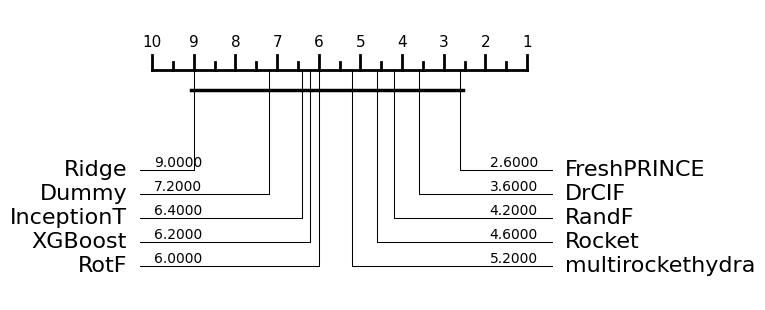

In [15]:
plt, _ = plot_critical_difference(
    np.array(table), list(table.columns), lower_better=True
)
plt.show()

# Classifier

In [16]:
# TODO whats the proper way to load the TSC results? same library?

# Make my own class



Features:
* For now only do wide not deep representation boosting
* percentage of dataset to be used at each boosting iteration
* Batching to calculate random features
* Do i need batching for least squares?
* What solver to use for least squares?
* How to initialize Phi_0? Should i use different n_features for the initial guess? Use all data for initial?



Would be interesting to see difference between boosting in label space vs representation boosting